# the purpose of this analysis is to use transfermarkt data to answer the following question:

Question 2) 
    Does age distribution in a team have an impact on the success/win rate?
    What were the age distributions of the most successful teams?

In [91]:
#import relevant libraries
#read in data files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_app = pd.read_csv('Data Files/appearances.csv')
df_club_games = pd.read_csv('Data Files/club_games.csv')
df_clubs = pd.read_csv('Data Files/clubs.csv')
df_competitions = pd.read_csv('Data Files/competitions.csv')
df_game_events = pd.read_csv('Data Files/game_events.csv')
df_games = pd.read_csv('Data Files/games.csv')
df_player_val = pd.read_csv('Data Files/player_valuations.csv')
df_players = pd.read_csv('Data Files/players.csv')

In [92]:
#function for deriving the result of the game
def calculate_results (own_goals, opp_goals):
    if own_goals > opp_goals:
        result = 'w'
    elif own_goals == opp_goals:
        result = 'd'
    else:
        result = 'l'
    return result

In [93]:
#create new dataframe for only the games that a player has actually played
df_player_games_played = pd.merge(df_app, df_club_games, left_on=['game_id', 'player_club_id'],
                                  right_on=['game_id', 'club_id'])

#apply result function
df_player_games_played["result"] = df_player_games_played.apply(lambda row: calculate_results (row['own_goals'], 
                                                                                row['opponent_goals']),
                                                               axis=1)

df_player_games_played = pd.merge(df_player_games_played, df_games[['game_id', 'season']], on='game_id')
df_player_games_played = pd.merge(df_player_games_played, df_players[['player_id', 'date_of_birth']], on='player_id')
df_player_games_played['date'] = pd.to_datetime(df_player_games_played['date'])
df_player_games_played['date_of_birth'] = pd.to_datetime(df_player_games_played['date_of_birth'])
df_player_games_played["age"] = ((df_player_games_played["date"] - df_player_games_played["date_of_birth"]).dt.days/365).round(0)

In [94]:
columns_to_drop = ['appearance_id', 'player_id',
       'player_current_club_id', 'date', 'player_name', 'competition_id',
       'yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played',
       'club_id', 'own_goals', 'own_manager_name',
       'opponent_id', 'opponent_goals', 'opponent_position',
       'opponent_manager_name', 'hosting', 'is_win', 'season',
       'date_of_birth', 'own_position']

#create an age distribution dataframe

df_age = df_player_games_played.drop(columns=columns_to_drop, axis=1)

In [95]:
#include information on mean age, age variance and min and max values
df_age_dist = df_age.groupby(['game_id', 'player_club_id'])['age'].agg(list).reset_index()
df_age_dist = df_age_dist.rename(columns={'age': 'age_dist'})
df_age_mean = df_age.groupby(['game_id', 'player_club_id'])['age'].mean().reset_index()
df_age_mean = df_age_mean.rename(columns={'age': 'mean_age'})
df_age_var = df_age.groupby(['game_id', 'player_club_id'])['age'].var().reset_index()
df_age_var = df_age_var.rename(columns={'age': 'var_age'})
df_age_min = df_age.groupby(['game_id', 'player_club_id'])['age'].min().reset_index()
df_age_min = df_age_min.rename(columns={'age': 'min_age'})
df_age_max = df_age.groupby(['game_id', 'player_club_id'])['age'].max().reset_index()
df_age_max = df_age_max.rename(columns={'age': 'max_age'})

#merge the data with the age distribution dataframe
df_age_dist = pd.merge(df_age_dist, df_age_mean, on=["game_id", "player_club_id"])
df_age_dist = pd.merge(df_age_dist, df_age_var, on=["game_id", "player_club_id"])
df_age_dist = pd.merge(df_age_dist, df_age_min, on=["game_id", "player_club_id"])
df_age_dist = pd.merge(df_age_dist, df_age_max, on=["game_id", "player_club_id"])

In [96]:
# derive information on the 25%-, 50%-, and 75%-quantile
df_age_dist["25%-q"] = df_age_dist["age_dist"].apply(lambda x: np.percentile(x, 25))
df_age_dist["50%-q"] = df_age_dist["age_dist"].apply(lambda x: np.percentile(x, 50))
df_age_dist["75%-q"] = df_age_dist["age_dist"].apply(lambda x: np.percentile(x, 75))

In [97]:
df_age_dist = df_age_dist.rename(columns={'player_club_id': 'club_id'})

In [98]:
df_club_games = pd.merge(df_club_games, df_games[["game_id", "season"]], on='game_id')

#apply result function
df_club_games["result"] = df_club_games.apply(lambda row: calculate_results (row['own_goals'], 
                                                                                row['opponent_goals']),
                                                               axis=1)

In [99]:
df_games_age = pd.merge(df_club_games, df_age_dist, on=["game_id", "club_id"])

In [100]:
df_games_age = pd.merge(df_games_age, df_age_dist, left_on=["game_id", "opponent_id"], right_on=["game_id", "club_id"])

In [101]:
df_games_age = df_games_age.rename(columns={'age_dist_x': 'age_dist_own'})
df_games_age = df_games_age.rename(columns={'mean_age_x': 'mean_age_own'})
df_games_age = df_games_age.rename(columns={'var_age_x': 'var_age_own'})
df_games_age = df_games_age.rename(columns={'min_age_x': 'min_age_own'})
df_games_age = df_games_age.rename(columns={'max_age_x': 'max_age_own'})
df_games_age = df_games_age.rename(columns={'25%-q_x': '25%-q_own'})
df_games_age = df_games_age.rename(columns={'50%-q_x': '50%-q_own'})
df_games_age = df_games_age.rename(columns={'75%-q_x': '75%-q_own'})

df_games_age = df_games_age.rename(columns={'age_dist_y': 'age_dist_opp'})
df_games_age = df_games_age.rename(columns={'mean_age_y': 'mean_age_op'})
df_games_age = df_games_age.rename(columns={'var_age_y': 'var_age_opp'})
df_games_age = df_games_age.rename(columns={'min_age_y': 'min_age_opp'})
df_games_age = df_games_age.rename(columns={'max_age_y': 'max_age_opp'})
df_games_age = df_games_age.rename(columns={'25%-q_y': '25%-q_opp'})
df_games_age = df_games_age.rename(columns={'50%-q_y': '50%-q_opp'})
df_games_age = df_games_age.rename(columns={'75%-q_y': '75%-q_opp'})

In [102]:
df_games_age = df_games_age.rename(columns={'club_id_x': 'club_id_own'})
df_games_age = df_games_age.rename(columns={'club_id_y': 'club_id_opp'})

In [103]:
df_games_age = df_games_age.drop(columns=['own_goals', 'own_position', 'own_manager_name', 'opponent_id',
                                         'opponent_goals', 'opponent_position','opponent_manager_name',
                                          'hosting'], axis = 1)

In [104]:
df_games_age.head()

,game_id,club_id_own,is_win,season,result,age_dist_own,mean_age_own,var_age_own,min_age_own,max_age_own,...,75%-q_own,club_id_opp,age_dist_opp,mean_age_op,var_age_opp,min_age_opp,max_age_opp,25%-q_opp,50%-q_opp,75%-q_opp
0,2457642,1269,1,2014,w,"[23.0, 23.0, 22.0, 23.0, 21.0, 20.0, 20.0, 29....",25.230769,24.525641,20.0,35.0,...,28.00,610,"[24.0, 22.0, 20.0, 20.0, 21.0, 19.0, 22.0, 20....",23.214286,11.719780,19.0,29.0,20.25,22.0,24.75
1,2457642,610,0,2014,l,"[24.0, 22.0, 20.0, 20.0, 21.0, 19.0, 22.0, 20....",23.214286,11.719780,19.0,29.0,...,24.75,1269,"[23.0, 23.0, 22.0, 23.0, 21.0, 20.0, 20.0, 29....",25.230769,24.525641,20.0,35.0,22.00,23.0,28.00
2,2459588,133,0,2014,d,"[22.0, 27.0, 20.0, 21.0, 30.0, 20.0, 30.0, 27....",24.857143,11.054945,20.0,30.0,...,27.00,317,"[23.0, 23.0, 23.0, 23.0, 20.0, 24.0, 17.0, 19....",23.000000,8.615385,17.0,28.0,22.25,23.0,24.75
3,2459588,317,0,2014,d,"[23.0, 23.0, 23.0, 23.0, 20.0, 24.0, 17.0, 19....",23.000000,8.615385,17.0,28.0,...,24.75,133,"[22.0, 27.0, 20.0, 21.0, 30.0, 20.0, 30.0, 27....",24.857143,11.054945,20.0,30.0,22.50,24.5,27.00
4,2459592,1435,0,2014,l,"[22.0, 27.0, 22.0, 23.0, 26.0, 22.0, 21.0, 21....",24.000000,12.461538,21.0,34.0,...,25.75,202,"[24.0, 24.0, 21.0, 33.0, 30.0, 27.0, 26.0, 24....",25.571429,10.571429,21.0,33.0,24.00,25.0,26.75


In [105]:
#calculate the metrics per club and season
df_season_age = df_games_age.groupby(['club_id_own', 'season'])['mean_age_own'].mean().reset_index()
df_season_var = df_games_age.groupby(['club_id_own', 'season'])['var_age_own'].mean().reset_index()
df_season_wins = df_games_age.groupby(['club_id_own', 'season'])['is_win'].sum().reset_index()
df_season_games = df_games_age.groupby(['club_id_own', 'season'])['result'].count().reset_index()
df_season_25 = df_games_age.groupby(['club_id_own', 'season'])['25%-q_own'].mean().reset_index()
df_season_50 = df_games_age.groupby(['club_id_own', 'season'])['50%-q_own'].mean().reset_index()
df_season_75 = df_games_age.groupby(['club_id_own', 'season'])['75%-q_own'].mean().reset_index()

In [106]:
#merge everything together
df_season_age = pd.merge(df_season_age, df_season_var, on=['club_id_own', 'season'])
df_season_age = pd.merge(df_season_age, df_season_wins, on=['club_id_own', 'season'])
df_season_age = pd.merge(df_season_age, df_season_games, on=['club_id_own', 'season'])
df_season_age = pd.merge(df_season_age, df_season_25, on=['club_id_own', 'season'])
df_season_age = pd.merge(df_season_age, df_season_50, on=['club_id_own', 'season'])
df_season_age = pd.merge(df_season_age, df_season_75, on=['club_id_own', 'season'])

In [107]:
#include only teams that have played more than 30 games
df_season_age = df_season_age[df_season_age["result"]>30]

In [108]:
#calculate the win rate per team and season
df_season_age["win_rate"] = df_season_age["is_win"]/ df_season_age["result"]

In [109]:
#calculate the correlation between the attributes
df_season_age.corr()

,club_id_own,season,mean_age_own,var_age_own,is_win,result,25%-q_own,50%-q_own,75%-q_own,win_rate
club_id_own,1.000000,0.047362,0.102316,-0.042439,-0.169439,-0.207769,0.116279,0.093550,0.067475,-0.144888
season,0.047362,1.000000,0.022306,0.144656,-0.001981,-0.043949,-0.014613,-0.004680,0.032907,0.018264
mean_age_own,0.102316,0.022306,1.000000,0.143077,-0.009503,0.051201,0.896170,0.946803,0.910378,-0.035226
var_age_own,-0.042439,0.144656,0.143077,1.000000,0.047695,0.079747,-0.233955,0.034290,0.381402,0.033450
is_win,-0.169439,-0.001981,-0.009503,0.047695,1.000000,0.737106,-0.031890,0.001749,0.001887,0.951600
result,-0.207769,-0.043949,0.051201,0.079747,0.737106,1.000000,0.011825,0.058204,0.066055,0.515786
25%-q_own,0.116279,-0.014613,0.896170,-0.233955,-0.031890,0.011825,1.000000,0.880550,0.684169,-0.049139
50%-q_own,0.093550,-0.004680,0.946803,0.034290,0.001749,0.058204,0.880550,1.000000,0.848979,-0.024195
75%-q_own,0.067475,0.032907,0.910378,0.381402,0.001887,0.066055,0.684169,0.848979,1.000000,-0.024468
win_rate,-0.144888,0.018264,-0.035226,0.033450,0.951600,0.515786,-0.049139,-0.024195,-0.024468,1.000000


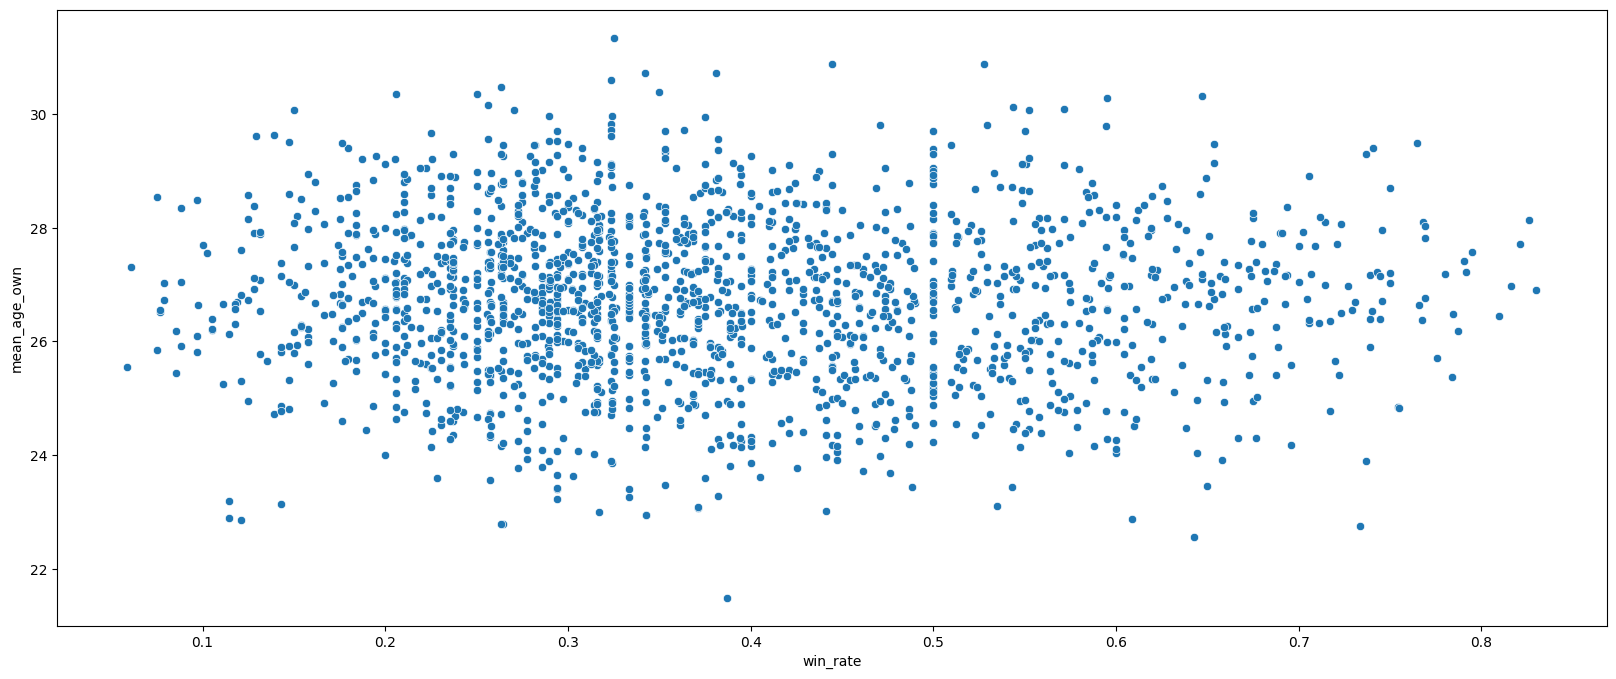

In [110]:
#create a scatterplot for win rate over mean age
plt.figure(figsize=(20, 8))

sns.scatterplot(data=df_season_age, x="win_rate", y="mean_age_own")

plt.show()

<Axes: xlabel='win_rate', ylabel='var_age_own'>

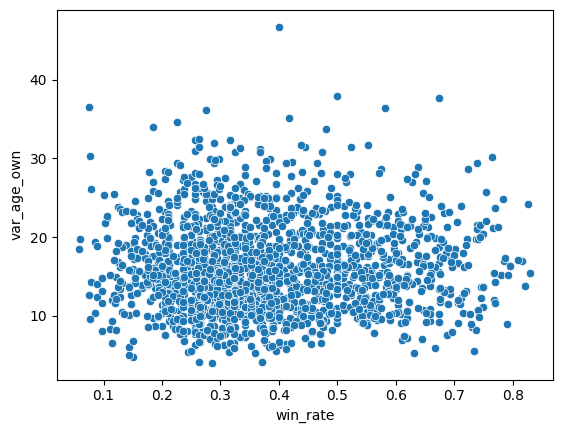

In [111]:
#create a scatterplot for win rate over age variance
sns.scatterplot(data=df_season_age, x="win_rate", y="var_age_own")

<Axes: xlabel='win_rate', ylabel='75%-q_own'>

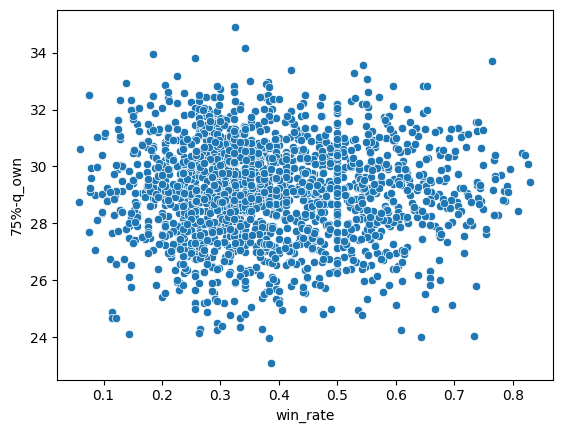

In [112]:
#create a scatterplot for win rate over 75% quantile
sns.scatterplot(data=df_season_age, x="win_rate", y="75%-q_own")

In [113]:
df_season_age.sort_values(by=['win_rate'], ascending=False).head(20)["mean_age_own"].mean()

27.126802012288568

In [114]:
df_season_age.sort_values(by=['win_rate'], ascending=False).head(20)["var_age_own"].mean()

17.599410711112437

In [115]:
df_season_age.sort_values(by=['win_rate'], ascending=False).head(20)["25%-q_own"].mean()

24.44852482816859

In [116]:
df_season_age.sort_values(by=['win_rate'], ascending=False).head(20)["50%-q_own"].mean()

26.94569369428566

In [117]:
df_season_age.sort_values(by=['win_rate'], ascending=False).head(20)["75%-q_own"].mean()

29.64485241362545

In [118]:
#show the metrics for the 20 most successful teams
print("The mean age for the 20 most successful clubs was " , round(df_season_age.sort_values(by=['win_rate'], ascending=False).head(20)["mean_age_own"].mean(),1))
print("The variance for the 20 most successful clubs was " ,round(df_season_age.sort_values(by=['win_rate'], ascending=False).head(20)["var_age_own"].mean(),1))
print("The 25%-quantile for the 20 most successful clubs was " ,round(df_season_age.sort_values(by=['win_rate'], ascending=False).head(20)["25%-q_own"].mean(),1))
print("The 50%-quantile for the 20 most successful clubs was " ,round(df_season_age.sort_values(by=['win_rate'], ascending=False).head(20)["50%-q_own"].mean(),1))
print("The 75%-quantile for the 20 most successful clubs was " ,round(df_season_age.sort_values(by=['win_rate'], ascending=False).head(20)["75%-q_own"].mean(),1))

The mean age for the 20 most successful clubs was  27.1
The variance for the 20 most successful clubs was  17.6
The 25%-quantile for the 20 most successful clubs was  24.4
The 50%-quantile for the 20 most successful clubs was  26.9
The 75%-quantile for the 20 most successful clubs was  29.6


In [119]:
df_season_age = pd.merge(df_season_age, df_clubs[["club_id", "name"]], left_on="club_id_own", right_on="club_id")

In [120]:
#show the 20 most successful teams with a median age lower than 25 years
df_season_age[(df_season_age["win_rate"]>0.5) & (df_season_age["mean_age_own"]<25)].sort_values(by=['mean_age_own'], ascending=True).head(30)

,club_id_own,season,mean_age_own,var_age_own,is_win,result,25%-q_own,50%-q_own,75%-q_own,win_rate,club_id,name
778,610,2016,22.563332,13.201935,36,56,20.125000,21.526786,23.995536,0.642857,610,Ajax Amsterdam
576,383,2014,22.764449,5.564996,33,45,21.022222,22.611111,24.044444,0.733333,383,PSV Eindhoven
777,610,2015,22.877150,9.055845,28,46,20.847826,22.510870,24.250000,0.608696,610,Ajax Amsterdam
776,610,2014,23.103118,11.219141,23,43,20.697674,22.720930,24.953488,0.534884,610,Ajax Amsterdam
1139,1090,2014,23.451648,9.991104,19,35,21.528571,23.000000,24.785714,0.542857,1090,AZ Alkmaar
779,610,2017,23.463626,22.340186,26,40,20.306250,21.687500,25.525000,0.650000,610,Ajax Amsterdam
579,383,2017,23.896780,8.246441,28,38,21.881579,23.552632,25.815789,0.736842,383,PSV Eindhoven
1142,1090,2017,23.909717,10.280136,25,38,21.164474,24.315789,25.835526,0.657895,1090,AZ Alkmaar
1144,1090,2019,24.036368,18.000595,21,35,20.914286,22.685714,26.957143,0.600000,1090,AZ Alkmaar
1788,23826,2018,24.040285,10.949734,27,47,21.382979,23.968085,26.760638,0.574468,23826,RB Leipzig


In [121]:
#show the 20 most successful teams with a median age higher than 29 years
df_season_age[(df_season_age["win_rate"]>0.5) & (df_season_age["mean_age_own"]>29)].sort_values(by=['mean_age_own'], ascending=True).head(20)

,club_id_own,season,mean_age_own,var_age_own,is_win,result,25%-q_own,50%-q_own,75%-q_own,win_rate,club_id,name
184,46,2022,29.028963,21.498572,29,50,26.010000,28.620000,31.730000,0.580000,46,Inter Milan
597,398,2022,29.093776,11.962247,24,42,27.726190,29.178571,30.226190,0.571429,398,SS Lazio
1811,41231,2021,29.122241,19.240660,17,31,26.064516,29.500000,32.201613,0.548387,41231,FC Sochi
458,281,2014,29.122267,9.048663,27,49,27.724490,28.948980,29.943878,0.551020,281,Manchester City
713,506,2019,29.128135,19.933078,34,52,26.572115,29.471154,32.000000,0.653846,506,Juventus FC
1676,6890,2016,29.229950,19.344139,21,38,27.434211,29.407895,32.078947,0.552632,6890,Basaksehir FK
710,506,2016,29.298442,19.793218,42,57,26.618421,29.324561,31.552632,0.736842,506,Juventus FC
711,506,2017,29.395231,19.720085,40,54,26.583333,29.555556,31.578704,0.740741,506,Juventus FC
317,150,2021,29.459793,16.640459,27,53,27.872642,29.094340,30.627358,0.509434,150,Real Betis Balompié
183,46,2021,29.475450,20.073753,34,52,26.000000,28.769231,32.817308,0.653846,46,Inter Milan


In [122]:
#show the count of top 20 most successful teams per season with a median age lower than 25 years
df_season_age[(df_season_age["win_rate"]>0.5) & (df_season_age["mean_age_own"]<25)].sort_values(by=['mean_age_own'], ascending=True).head(20)["name"].value_counts()


name
PSV Eindhoven          5
AZ Alkmaar             5
Ajax Amsterdam         4
RB Leipzig             2
Olympique Lyon         1
KRC Genk               1
Feyenoord Rotterdam    1
Stade Rennais FC       1
Name: count, dtype: int64

In [123]:
#show the count of top 20 most successful teams per season with a median age higher than 29 years
df_season_age[(df_season_age["win_rate"]>0.5) & (df_season_age["mean_age_own"]>29)].sort_values(by=['mean_age_own'], ascending=True).head(20)["name"].value_counts()


name
Basaksehir FK          4
Juventus FC            3
Inter Milan            2
Besiktas JK            2
Fenerbahce             2
SS Lazio               1
FC Sochi               1
Manchester City        1
Real Betis Balompié    1
Galatasaray            1
Adana Demirspor        1
Olympiacos Piraeus     1
Name: count, dtype: int64